In [1]:
!pip install ..\abides-core
!pip install ..\abides-markets

Processing c:\users\marek.koza\abides-jpmc-public\abides-core
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for abides-core: filename=abides_core-0.0.0-py3-none-any.whl size=29886 sha256=a9781312991eccd8718600fdf7cdcb380a2cbd47fbc3188e0814c6db46039dba
  Stored in directory: c:\users\marek.koza\appdata\local\pip\cache\wheels\e5\d3\5f\6b62065daab9aa95d51d1aa61064f7197b49211367d7397920
Successfully built abides-core
  Attempting uninstall: abides-core
    Found existing installation: abides-core 0.0.0
    Uninstalling abides-core-0.0.0:
      Successfully uninstalled abides-core-0.0.0


You should consider upgrading via the 'C:\Users\marek.koza\anaconda3\python.exe -m pip install --upgrade pip' command.


Processing c:\users\marek.koza\abides-jpmc-public\abides-markets
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for abides-markets: filename=abides_markets-0.0.0-py3-none-any.whl size=104654 sha256=5f67348107de95f1f017a281a9f4a7223581f0fb6f99aeca9c1f6d5de58ccf8e
  Stored in directory: c:\users\marek.koza\appdata\local\pip\cache\wheels\ae\69\89\d26c9b91cff29f90a91d001b39d390c1a64100b7611c9c9968
Successfully built abides-markets
  Attempting uninstall: abides-markets
    Found existing installation: abides-markets 0.0.0
    Uninstalling abides-markets-0.0.0:
      Successfully uninstalled abides-markets-0.0.0


You should consider upgrading via the 'C:\Users\marek.koza\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
import datetime as dt 
import time
from abides_core.utils import get_wake_time, str_to_ns, parse_logs_df
from copy import deepcopy
from abides_markets.models import OrderSizeModel
from abides_markets.configs import communication
from abides_markets.configs.utils import generate_BA_graph_sequence
from abides_markets.agents.network_agents.utils import insider_network_plot, generate_bests_df, updated_holdings,executed_orders,final_surplus
from itertools import count
import numpy as np
from abides_core import abides

date = dt.date.today()
date = int(time.mktime(date.timetuple())) * 1000_000_000

In [3]:
# parametry podstawowe (wspólne): godziny rozpoczęcia i zamknięcia sesji, symbol instrumentu
mkt_open = date + str_to_ns("09:00:00")
mkt_close = date + str_to_ns("17:00:00")
symbol = "ABM"
order_size_model = OrderSizeModel()
starting_cash = 10_000_000
r_bar = 100_000
kappa_oracle = 1.67e-16
kappa = 1.67e-15
lambda_a=5.7e-12
sigma_s = 0
fund_vol = 5e-5
megashock_lambda_a = 2.77778e-18
megashock_mean = 1000
megashock_var = 50_000
sigma_n = r_bar / 100 

In [4]:
# seedy 
sim_seed = np.random.randint(low=0, high=2 ** 32, dtype=np.int64)

In [5]:
# wyrocznia 0: brak wydarzeń 
events_oracle_0 = {}

# wyrocznia 1: gwałtowny spadek 
events_oracle_1 = {symbol: [{"SpecialEventTime":mkt_open+str_to_ns("3h"), "SpecialEventValue": -10000}]}

# wyrocznia 2: gwałtowny wzrost 
events_oracle_2 = {symbol: [{"SpecialEventTime":mkt_open+str_to_ns("3h"), "SpecialEventValue": 10000}]}

# wyrocznia 3: gwałtowny wzrost, następnie gwałtowny spadek 
events_oracle_3 = {symbol: [{"SpecialEventTime":mkt_open+str_to_ns("3h"), "SpecialEventValue": 10000},
                            {"SpecialEventTime":mkt_open+str_to_ns("5h"), "SpecialEventValue": -8000}]}
    
# wyrocznia 4: gwałtowny spadek, następnie gwałtowny wzrost 
events_oracle_3 = {symbol: [{"SpecialEventTime":mkt_open+str_to_ns("3h"), "SpecialEventValue": -10000},{"SpecialEventTime":mkt_open+str_to_ns("5h"), "SpecialEventValue": 8000}]}
    

In [6]:
# pozostałe parametry wyroczni 
oracle_params = {
            "r_bar": r_bar,
            "kappa": kappa_oracle,
            "sigma_s": sigma_s,
            "fund_vol": fund_vol,
            "megashock_lambda_a": megashock_lambda_a,
            "megashock_mean": megashock_mean,
            "megashock_var": megashock_var,
    }


In [7]:
# parametry ValueAgents 
value_agents_params = {
                "symbol": symbol,
                "starting_cash":starting_cash,
                "sigma_n":sigma_n,
                "r_bar":r_bar,
                "kappa":kappa,
                "lambda_a":lambda_a,
                "log_orders":True,
                "order_size_model":order_size_model,
                "random_state": np.random.RandomState(
                    seed=np.random.randint(low=0, high=2 ** 32, dtype="uint64"))

}

In [8]:
# parametry NoiseAgents 
noise_agents_params = {
                "symbol":symbol,
                "starting_cash":starting_cash,
                "wakeup_time": get_wake_time(mkt_open - str_to_ns("00:30:00") , mkt_close + str_to_ns("00:30:00")),
                "log_orders":True,
                "order_size_model": order_size_model,
                "random_state": np.random.RandomState(
                    seed=np.random.randint(low=0, high=2 ** 32, dtype="uint64"))}

In [9]:
# parametry insidera 
horizon = str_to_ns("1h")
insider_value_agents_params = deepcopy(value_agents_params)
insider_value_agents_params['horizon'] = horizon 


In [10]:
# maksymalne liczby agentów w sieci insidera 
num_insiders = 1
num_value_followers = 102 - num_insiders
num_noise_followers = 1000
id_generator = count(1)

In [11]:
insiders, follower_value_agents, follower_noise_agents = communication.generate_agents(num_insiders, num_value_followers, num_noise_followers, id_generator, insider_value_agents_params,
                    value_agents_params, noise_agents_params)

In [12]:
followers = follower_value_agents
followers.extend(follower_noise_agents)

In [13]:
starting_graph, other_agents = communication.generate_starting_graph(insiders, followers)

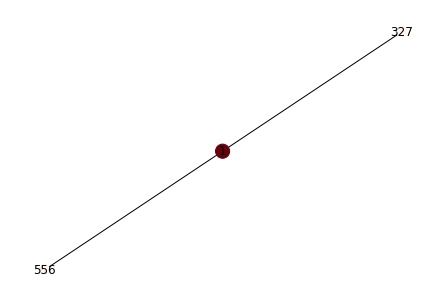

In [14]:
insider_network_plot(starting_graph)

In [15]:
graph_sizes=[5,10,25,50,100,250,500, 1000, 1100]
graph_generator = generate_BA_graph_sequence(starting_graph = starting_graph, m=2, new_agents=other_agents,
                               graph_sizes=graph_sizes)
bests = []
orders = []
holdings = []
surplus = []


def config_name_generator(graph_sizes):
    for graph_size in iter(graph_sizes):
        yield f"test_oracle_0_insiders_{num_insiders}_netsize_{graph_size}"
name_gen = config_name_generator(graph_sizes)

In [16]:
for graph in graph_generator: 
    # eventy mogą być inne
    sim_config = communication.build_config(graph, events_oracle_0,mkt_open, mkt_close,seed = sim_seed, oracle_seed=sim_seed, **oracle_params)
    end_state = abides.run(config=sim_config)
    config_name = next(name_gen)
    bests.append(generate_bests_df(end_state=end_state, symbol=symbol, config_name=config_name))
    logs = parse_logs_df(end_state)
    holdings.append(updated_holdings(logs=logs, config_name=config_name, symbol=symbol))
    orders.append(executed_orders(logs=logs, config_name=config_name))
    surplus.append(final_surplus(logs=logs, config_name=config_name))

[12452] INFO abides Simulation Start Time: 2023-06-14 00:58:12.625414
[12452] INFO abides_core.kernel --- Simulation time: 2021-02-05 00:00:00, messages processed: 0, wallclock elapsed: 0.00s ---
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 507 @ 2023-06-14 07:04:56) : BID 100 ABM @ $1000.65 (filled @ $1000.65)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 272 @ 2023-06-14 07:57:37) : ASK 100 ABM @ $1002.52 (filled @ $1002.52)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 399 @ 2023-06-14 08:01:

C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 548 @ 2023-06-14 13:54:29) : ASK 54 ABM @ $1002.33 (filled @ $1002.33)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 548 @ 2023-06-14 13:54:29) : ASK 46 ABM @ $1002.33 (filled @ $1002.33)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 415 @ 2023-06-14 13:57:51) : ASK 4 ABM @ $1002.35 (filled @ $1002.35)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trad

C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 287 @ 2023-06-14 14:38:09) : ASK 47 ABM @ $1002.18 (filled @ $1002.18)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 287 @ 2023-06-14 14:38:09) : ASK 53 ABM @ $1002.18 (filled @ $1002.18)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 387 @ 2023-06-14 14:38:29) : BID 136 ABM @ $1002.20 (filled @ $1002.20)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\tr

[12452] INFO abides_core.kernel Event Queue elapsed: 0:00:43.589819, messages: 658,712, messages per second: 15111.6
[12452] INFO abides_core.kernel Mean ending value by agent type:
[12452] INFO abides_core.kernel InsiderValueAgent: 397003
[12452] INFO abides_core.kernel FollowerValueAgent: 0
[12452] INFO abides_core.kernel NoiseAgent: 116
[12452] INFO abides_core.kernel FollowerNoiseAgent: 0
[12452] INFO abides_core.kernel ValueAgent: 335130
[12452] INFO abides_core.kernel AdaptivePOVMarketMakerAgent: -641104
[12452] INFO abides_core.kernel MomentumAgent: -2700682
[12452] INFO abides_core.kernel Simulation ending!
[12452] INFO abides Simulation End Time: 2023-06-14 00:59:03.328000
[12452] INFO abides Time taken to run simulation: 0:00:50.702586
[12452] INFO abides Simulation Start Time: 2023-06-14 00:59:09.276804
[12452] INFO abides_core.kernel --- Simulation time: 2021-02-05 00:00:00, messages processed: 0, wallclock elapsed: 0.00s ---
C:\Users\marek.koza\anaconda3\lib\site-packages\

C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 553 @ 2023-06-14 13:54:29) : ASK 1 ABM @ $1005.68 (filled @ $1005.68)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 553 @ 2023-06-14 13:54:29) : ASK 19 ABM @ $1005.68 (filled @ $1005.68)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 553 @ 2023-06-14 13:54:29) : ASK 80 ABM @ $1005.68 (filled @ $1005.68)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trad

C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 534 @ 2023-06-14 14:28:42) : ASK 36 ABM @ $1004.03 (filled @ $1004.03)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 207 @ 2023-06-14 14:30:12) : BID 9 ABM @ $1003.90 (filled @ $1003.90)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 207 @ 2023-06-14 14:30:12) : BID 91 ABM @ $1003.90 (filled @ $1003.90)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trad

C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 158 @ 2023-06-14 14:53:43) : ASK 59 ABM @ $1003.69 (filled @ $1003.69)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 275 @ 2023-06-14 14:53:43) : ASK 99 ABM @ $1003.68 (filled @ $1003.68)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 275 @ 2023-06-14 14:53:43) : ASK 100 ABM @ $1003.68 (filled @ $1003.68)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\tr

C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 389 @ 2023-06-14 09:01:03) : BID 2 ABM @ $1000.42 (filled @ $1000.42)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 389 @ 2023-06-14 09:01:03) : BID 14 ABM @ $1000.42 (filled @ $1000.42)
  warnings.warn(f"Execution received for order not in orders list: {order}")
[12452] INFO abides_core.kernel --- Simulation time: 2023-06-14 09:09:27, messages processed: 200,000, wallclock elapsed: 11.18s ---
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 512 @ 2023-06-14 09:45:44) : BID 33 ABM @ $1001.04 (filled @ $1001.04)
  warnings.warn(f"

C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 36 @ 2023-06-14 14:20:02) : ASK 4 ABM @ $1004.08 (filled @ $1004.08)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 58 @ 2023-06-14 14:23:24) : ASK 53 ABM @ $1003.84 (filled @ $1003.84)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 58 @ 2023-06-14 14:23:24) : ASK 47 ABM @ $1003.84 (filled @ $1003.84)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading

C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 173 @ 2023-06-14 14:53:43) : ASK 100 ABM @ $1002.79 (filled @ $1002.79)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 290 @ 2023-06-14 14:53:43) : ASK 100 ABM @ $1002.79 (filled @ $1002.79)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 290 @ 2023-06-14 14:53:43) : ASK 198 ABM @ $1002.79 (filled @ $1002.79)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\

[12452] INFO abides_core.kernel --- Simulation time: 2023-06-14 11:03:48, messages processed: 300,000, wallclock elapsed: 17.70s ---
[12452] INFO abides_core.kernel --- Simulation time: 2023-06-14 11:47:14, messages processed: 400,000, wallclock elapsed: 22.21s ---
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 389 @ 2023-06-14 12:29:44) : ASK 8 ABM @ $1001.25 (filled @ $1001.25)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 389 @ 2023-06-14 12:29:44) : ASK 92 ABM @ $1001.25 (filled @ $1001.25)
  warnings.warn(f"Execution received for order not in orders list: {order}")
[12452] INFO abides_core.kernel --- Simulation time: 2023-06-14 12:51:06, messages processed: 500,000, wallclock elap

C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 247 @ 2023-06-14 14:30:12) : BID 50 ABM @ $1002.71 (filled @ $1002.71)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 141 @ 2023-06-14 14:31:49) : ASK 100 ABM @ $1002.06 (filled @ $1002.06)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 156 @ 2023-06-14 14:35:03) : ASK 75 ABM @ $1001.52 (filled @ $1001.52)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\tr

[12452] INFO abides_core.kernel Event Queue elapsed: 0:00:37.008340, messages: 621,691, messages per second: 16798.7
[12452] INFO abides_core.kernel Mean ending value by agent type:
[12452] INFO abides_core.kernel InsiderValueAgent: 669994
[12452] INFO abides_core.kernel FollowerValueAgent: 433554
[12452] INFO abides_core.kernel NoiseAgent: -484
[12452] INFO abides_core.kernel FollowerNoiseAgent: 0
[12452] INFO abides_core.kernel ValueAgent: 536109
[12452] INFO abides_core.kernel AdaptivePOVMarketMakerAgent: -244340
[12452] INFO abides_core.kernel MomentumAgent: -4085401
[12452] INFO abides_core.kernel Simulation ending!
[12452] INFO abides Simulation End Time: 2023-06-14 01:01:40.157003
[12452] INFO abides Time taken to run simulation: 0:00:42.690316
[12452] INFO abides Simulation Start Time: 2023-06-14 01:01:45.667128
[12452] INFO abides_core.kernel --- Simulation time: 2021-02-05 00:00:00, messages processed: 0, wallclock elapsed: 0.00s ---
C:\Users\marek.koza\anaconda3\lib\site-pac

C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 402 @ 2023-06-14 13:54:20) : BID 31 ABM @ $1001.01 (filled @ $1001.01)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 402 @ 2023-06-14 13:54:20) : BID 69 ABM @ $1001.01 (filled @ $1001.01)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 510 @ 2023-06-14 13:57:51) : ASK 4 ABM @ $1001.01 (filled @ $1001.01)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trad

C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 482 @ 2023-06-14 14:38:29) : BID 7 ABM @ $1002.44 (filled @ $1002.44)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 482 @ 2023-06-14 14:38:29) : BID 100 ABM @ $1002.44 (filled @ $1002.44)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 482 @ 2023-06-14 14:38:29) : BID 93 ABM @ $1002.44 (filled @ $1002.44)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\tra

[12452] INFO abides Simulation End Time: 2023-06-14 01:02:23.887745
[12452] INFO abides Time taken to run simulation: 0:00:38.220617
[12452] INFO abides Simulation Start Time: 2023-06-14 01:02:29.649380
[12452] INFO abides_core.kernel --- Simulation time: 2021-02-05 00:00:00, messages processed: 0, wallclock elapsed: 0.00s ---
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 373 @ 2023-06-14 07:32:53) : BID 90 ABM @ $1001.25 (filled @ $1001.25)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 373 @ 2023-06-14 07:32:53) : BID 10 ABM @ $1001.25 (filled @ $1001.25)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abide

C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 504 @ 2023-06-14 14:08:54) : BID 6 ABM @ $1001.04 (filled @ $1001.04)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 261 @ 2023-06-14 14:20:02) : ASK 4 ABM @ $1001.53 (filled @ $1001.53)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trading_agent.py:808: UserWarning: Execution received for order not in orders list: (Agent 439 @ 2023-06-14 14:23:23) : BID 100 ABM @ $1001.75 (filled @ $1001.75)
  warnings.warn(f"Execution received for order not in orders list: {order}")
C:\Users\marek.koza\anaconda3\lib\site-packages\abides_markets\agents\trad

[12452] INFO abides_core.kernel Event Queue elapsed: 0:00:21.946449, messages: 340,184, messages per second: 15500.6
[12452] INFO abides_core.kernel Mean ending value by agent type:
[12452] INFO abides_core.kernel InsiderValueAgent: 808906
[12452] INFO abides_core.kernel FollowerValueAgent: 288287
[12452] INFO abides_core.kernel FollowerNoiseAgent: 416
[12452] INFO abides_core.kernel NoiseAgent: 88
[12452] INFO abides_core.kernel AdaptivePOVMarketMakerAgent: 0
[12452] INFO abides_core.kernel MomentumAgent: -2505190
[12452] INFO abides_core.kernel Simulation ending!
[12452] INFO abides Simulation End Time: 2023-06-14 01:02:54.781580
[12452] INFO abides Time taken to run simulation: 0:00:25.132200
[12452] INFO abides Simulation Start Time: 2023-06-14 01:03:01.837530
[12452] INFO abides_core.kernel --- Simulation time: 2021-02-05 00:00:00, messages processed: 0, wallclock elapsed: 0.00s ---
[12452] INFO abides_core.kernel --- Simulation time: 2023-06-14 08:43:23, messages processed: 100,0

[12452] INFO abides_core.kernel --- Simulation time: 2023-06-14 11:54:16, messages processed: 800,000, wallclock elapsed: 33.31s ---
[12452] INFO abides_core.kernel --- Simulation time: 2023-06-14 12:44:42, messages processed: 900,000, wallclock elapsed: 37.89s ---
[12452] INFO abides_core.kernel --- Simulation time: 2023-06-14 13:40:14, messages processed: 1,000,000, wallclock elapsed: 42.57s ---
[12452] INFO abides_core.kernel --- Simulation time: 2023-06-14 14:28:59, messages processed: 1,100,000, wallclock elapsed: 47.48s ---
[12452] INFO abides_core.kernel Event Queue elapsed: 0:00:50.646357, messages: 1,172,445, messages per second: 23149.6
[12452] INFO abides_core.kernel Mean ending value by agent type:
[12452] INFO abides_core.kernel InsiderValueAgent: 596528
[12452] INFO abides_core.kernel FollowerValueAgent: 511745
[12452] INFO abides_core.kernel FollowerNoiseAgent: 553
[12452] INFO abides_core.kernel NoiseAgent: 8450
[12452] INFO abides_core.kernel AdaptivePOVMarketMakerAgen

In [17]:
graph_generator = generate_BA_graph_sequence(starting_graph = starting_graph, m=2, new_agents=other_agents,
                               graph_sizes=graph_sizes)

In [18]:
next(graph_generator)

In [19]:
holdings[1]['agent_type'].unique()

array(['InsiderValueAgent', 'FollowerValueAgent', 'NoiseAgent',
       'FollowerNoiseAgent', 'ValueAgent', 'AdaptivePOVMarketMakerAgent',
       'MomentumAgent'], dtype=object)

In [20]:
surplus[8][1050:1100]

ScalarEventValue                 
EventType                    FINAL_VALUATION STARTING_CASH   
agent_id agent_type                                          
1051     FollowerNoiseAgent       10000000.0    10000000.0  \
1052     FollowerNoiseAgent       10000000.0    10000000.0   
1053     FollowerNoiseAgent       10000000.0    10000000.0   
1054     FollowerNoiseAgent        -0.541329    10000000.0   
1055     FollowerNoiseAgent       10000000.0    10000000.0   
1056     FollowerNoiseAgent        -1.984851    10000000.0   
1057     FollowerNoiseAgent        -0.992693    10000000.0   
1058     FollowerNoiseAgent       10000000.0    10000000.0   
1059     FollowerNoiseAgent        -0.991525    10000000.0   
1060     FollowerNoiseAgent       10000000.0    10000000.0   
1061     FollowerNoiseAgent       10000000.0    10000000.0   
1062     FollowerNoiseAgent       10000000.0    10000000.0   
1063     FollowerNoiseAgent       10000000.0    10000000.0   
1064     FollowerNoiseAgent       10000000.0    10000000.0   
1065     FollowerNoiseAgent       10000000.0    10000000.0   
1066     FollowerNoiseAgent         0.990822    10000000.0   
1067     FollowerNoiseAgent        -0.993069    10000000.0   
1068     FollowerNoiseAgent       10000000.0    10000000.0   
1069     FollowerNoiseAgent       10000000.0    10000000.0   
1070     FollowerNoiseAgent       10000000.0    10000000.0   
1071     FollowerNoiseAgent       10000000.0    10000000.0   
1072     FollowerNoiseAgent       10000000.0    10000000.0   
1073     FollowerNoiseAgent         0.350206    10000000.0   
1074     FollowerNoiseAgent         0.090299    10000000.0   
1075     FollowerNoiseAgent       10000000.0    10000000.0   
1076     FollowerNoiseAgent       10000000.0    10000000.0   
1077     FollowerNoiseAgent       10000000.0    10000000.0   
1078     FollowerNoiseAgent       10000000.0    10000000.0   
1079     FollowerNoiseAgent         0.080188    10000000.0   
1080     FollowerNoiseAgent       10000000.0    10000000.0   
1081     FollowerNoiseAgent         0.060035    10000000.0   
1082     FollowerNoiseAgent       10000000.0    10000000.0   
1083     FollowerNoiseAgent         3.972434    10000000.0   
1084     FollowerNoiseAgent       10000000.0    10000000.0   
1085     FollowerNoiseAgent       10000000.0    10000000.0   
1086     FollowerNoiseAgent        -0.991079    10000000.0   
1087     FollowerNoiseAgent         0.993277    10000000.0   
1088     FollowerNoiseAgent       10000000.0    10000000.0   
1089     FollowerNoiseAgent       10000000.0    10000000.0   
1090     FollowerNoiseAgent         0.250872    10000000.0   
1091     FollowerNoiseAgent       10000000.0    10000000.0   
1092     FollowerNoiseAgent       10000000.0    10000000.0   
1093     FollowerNoiseAgent       10000000.0    10000000.0   
1094     FollowerNoiseAgent       10000000.0    10000000.0   
1095     FollowerNoiseAgent       10000000.0    10000000.0   
1096     FollowerNoiseAgent        -3.971999    10000000.0   
1097     FollowerNoiseAgent       10000000.0    10000000.0   
1098     FollowerNoiseAgent       10000000.0    10000000.0   
1099     FollowerNoiseAgent         0.991614    10000000.0   
1100     FollowerNoiseAgent       10000000.0    10000000.0   

                                                       config_name  
EventType                                                           
agent_id agent_type                                                 
1051     FollowerNoiseAgent  test_oracle_0_insiders_1_netsize_1100  
1052     FollowerNoiseAgent  test_oracle_0_insiders_1_netsize_1100  
1053     FollowerNoiseAgent  test_oracle_0_insiders_1_netsize_1100  
1054     FollowerNoiseAgent  test_oracle_0_insiders_1_netsize_1100  
1055     FollowerNoiseAgent  test_oracle_0_insiders_1_netsize_1100  
1056     FollowerNoiseAgent  test_oracle_0_insiders_1_netsize_1100  
1057     FollowerNoiseAgent  test_oracle_0_insiders_1_netsize_1100  
1058     FollowerNoiseAgent  test_oracle_0_insiders

<AxesSubplot:xlabel='time'>

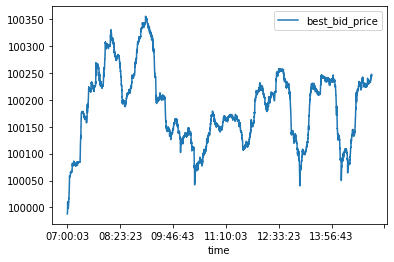

In [21]:
bests[0].plot(x="time", y="best_bid_price")

<AxesSubplot:xlabel='time'>

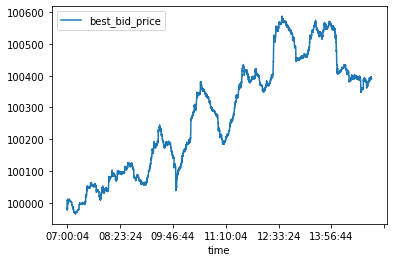

In [22]:
bests[1].plot(x="time", y="best_bid_price")

<AxesSubplot:xlabel='time'>

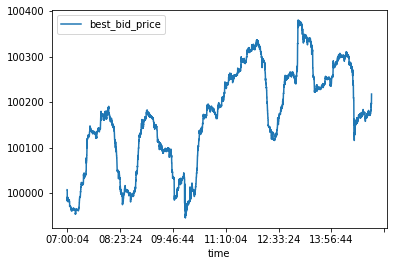

In [26]:
bests[3].plot(x="time", y="best_bid_price")

<AxesSubplot:xlabel='time'>

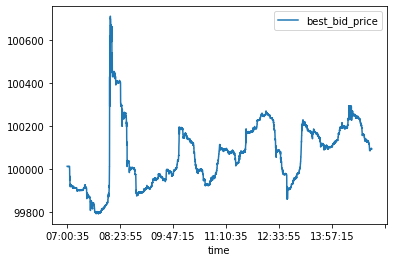

In [27]:
bests[4].plot(x="time", y="best_bid_price")

<AxesSubplot:xlabel='time'>

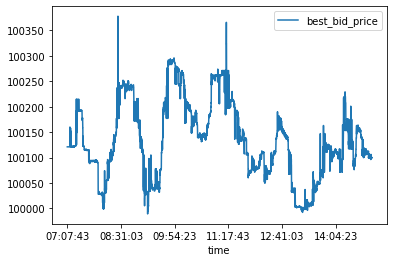

In [28]:
bests[5].plot(x="time", y="best_bid_price")

<AxesSubplot:xlabel='time'>

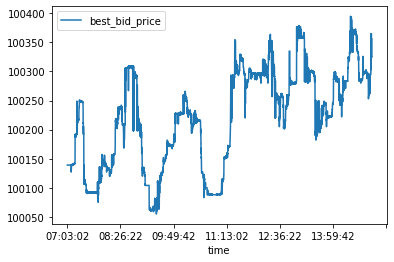

In [29]:
bests[6].plot(x="time", y="best_bid_price")

<AxesSubplot:xlabel='time'>

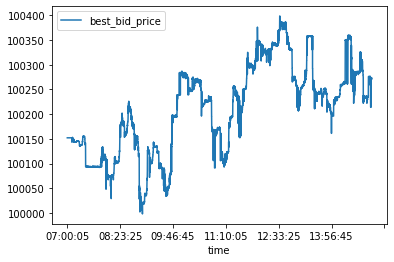

In [23]:
bests[7].plot(x="time", y="best_bid_price")

<AxesSubplot:xlabel='time'>

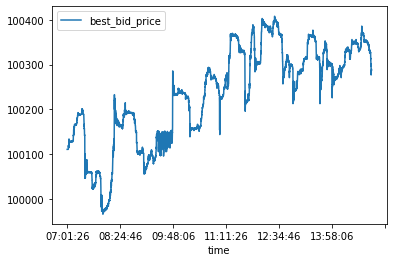

In [30]:
bests[8].plot(x="time", y="best_bid_price")

In [24]:
holdings[1]

,EventTime,agent_id,agent_type,CASH,ABM,config_name
1,1612483200000000000,1,InsiderValueAgent,10000000.0,NaN,test_oracle_0_insiders_1_netsize_10
8,1686726217677648305,1,InsiderValueAgent,17500825.0,-75.0,test_oracle_0_insiders_1_netsize_10
17,1686726481321067108,1,InsiderValueAgent,16800867.0,-68.0,test_oracle_0_insiders_1_netsize_10
19,0,1,InsiderValueAgent,16100909.0,-61.0,test_oracle_0_insiders_1_netsize_10
26,0,1,InsiderValueAgent,26099509.0,-161.0,test_oracle_0_insiders_1_netsize_10
...,...,...,...,...,...,...
5698,1686754744667499056,1116,MomentumAgent,-735312930.0,7428.0,test_oracle_0_insiders_1_netsize_10
5701,1686754745011611284,1116,MomentumAgent,-728486002.0,7360.0,test_oracle_0_insiders_1_netsize_10
5707,1686754767338343622,1116,MomentumAgent,-738525502.0,7460.0,test_oracle_0_insiders_1_netsize_10
5713,1686754788640050351,1116,MomentumAgent,-740332612.0,7478.0,test_oracle_0_insiders_1_netsize_10


In [25]:
holdings[5]

,EventTime,agent_id,agent_type,CASH,ABM,config_name
1,1612483200000000000,1,InsiderValueAgent,10000000.0,NaN,test_oracle_0_insiders_1_netsize_250
8,0,1,InsiderValueAgent,-12100.0,100.0,test_oracle_0_insiders_1_netsize_250
21,1686727029675810524,1,InsiderValueAgent,-10024400.0,200.0,test_oracle_0_insiders_1_netsize_250
35,0,1,InsiderValueAgent,-16232026.0,262.0,test_oracle_0_insiders_1_netsize_250
37,1686727191138889571,1,InsiderValueAgent,-18634978.0,286.0,test_oracle_0_insiders_1_netsize_250
...,...,...,...,...,...,...
4994,1686754790936438009,1116,MomentumAgent,658912478.0,-6505.0,test_oracle_0_insiders_1_netsize_250
4996,1686754790936438059,1116,MomentumAgent,660013578.0,-6516.0,test_oracle_0_insiders_1_netsize_250
5002,1686754791092991883,1116,MomentumAgent,668922478.0,-6605.0,test_oracle_0_insiders_1_netsize_250
5005,1686754793002400365,1116,MomentumAgent,678932478.0,-6705.0,test_oracle_0_insiders_1_netsize_250
